In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import json
import tensorflow as tf

import matplotlib.pyplot as plt

from signlens.params import *
from signlens.preprocessing.glossary import load_glossary, write_glossary
from signlens.preprocessing.data import load_data_subset_csv , load_video_list_json
from signlens.preprocessing.preprocess import encode_labels, decode_labels, pad_and_preprocess_sequences_from_pq_file_path_df, preprocess_data_from_json_data, pad_and_preprocess_landmarks_array, reshape_processed_data_to_tf, convert_landmarks_json_data_to_df, filter_relevant_landmarks_and_coordinates
from signlens.model.model_utils import load_model
from signlens.model.model_architecture import evaluate_model
from utils.video_utils import process_video_to_landmarks_json, draw_landmarks_on_image

from colorama import Fore, Style

%load_ext autoreload

%autoreload 2


2024-03-27 22:11:00.219628: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-27 22:11:01.249440: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Glossary check

In [4]:
#write_glossary()

In [2]:
glossary = load_glossary()

In [3]:
len(glossary.index.unique())

250

## Prediction on parquet files

In [4]:
# Load model
model_file = "model_20240327-2145epoch_10.keras"
model_path = os.path.join('/home/bfrisque/code/benoitfrisque/signlens/', 'models_api', model_file)
model = load_model(mode='from_path', model_path=model_path)


2024-03-27 22:11:11.812610: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-27 22:11:11.813126: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
test_data = load_data_subset_csv(balanced=True, csv_path=TRAIN_TEST_CSV_PATH, random_state=42, frac=0.1)
X_test_files = test_data.file_path

# Preprocessing
print(Fore.BLUE + f"\nPreprocessing {len(X_test_files)} testing files..." + Style.RESET_ALL)
X_test = pad_and_preprocess_sequences_from_pq_file_path_df(X_test_files)
y_test = encode_labels(test_data.sign)


metrics_dict = evaluate_model(model, X_test, y_test)
accuracy = metrics_dict['accuracy']


Loading data subset from train_test.csv
    ℹ️ Random state set for data loading : 42
    ℹ️ Filtered sequences with missing frames. Size reduced from 17233 to 17233 (100.00%)
    ℹ️ Filtered on n_frames = 100. Size reduced from 17233 to 17233 (100.00%)
    ℹ️ Filtered on n_classes = 250. Size reduced from 17233 to 17233 (100.00%)
    ℹ️ Balanced data, with average of 6.9 elements per class. Size reduced from 17233 to 1723 (10.00%)
✅ Loaded 1723 rows (10.00% of the original 17233 rows) from the dataset.

Preprocessing 1723 testing files...


/home/bfrisque/.pyenv/versions/3.10.6/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1723/1723 [00:03<00:00, 455.09it/s]



Evaluating model on 1723 rows...
✅ Model evaluated, accuracy: 32.0%


## Prediction on json from videos

### Select test set

In [9]:
videos = load_video_list_json(filter_glossary=True)

In [42]:
# test_videos = videos.sample(n=500, random_state=42)
test_videos = videos.sample(n=400, random_state=42)

In [43]:
test_videos 

,sign,bbox,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,video_path
1125,on,"[29, 0, 267, 240]",25,-1,1,3,37,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/4...,0,39839,/home/bfrisque/code/benoitfrisque/signlens/raw...
184,white,"[183, 52, 544, 400]",25,-1,1,16,12,aslsearch,train,http://www.aslsearch.com/signs/videos/white.mp4,0,63214,/home/bfrisque/code/benoitfrisque/signlens/raw...
1226,water,"[89, 22, 204, 192]",25,-1,1,6,10,signingsavvy,train,https://www.signingsavvy.com/signs/mp4/22/2297...,0,62506,/home/bfrisque/code/benoitfrisque/signlens/raw...
67,jump,"[167, 16, 480, 370]",25,-1,1,1,90,aslsignbank,train,https://aslsignbank.haskins.yale.edu/dictionar...,0,65983,/home/bfrisque/code/benoitfrisque/signlens/raw...
220,yes,"[168, 14, 461, 370]",25,-1,1,13,88,aslsignbank,train,https://aslsignbank.haskins.yale.edu/dictionar...,0,66820,/home/bfrisque/code/benoitfrisque/signlens/raw...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
704,all,"[439, 68, 1366, 1080]",25,-1,1,1,115,aslbrick,train,http://aslbricks.org/New/ASL-Videos/all.mp4,0,69206,/home/bfrisque/code/benoitfrisque/signlens/raw...
126,find,"[187, 52, 572, 400]",25,-1,1,11,12,aslsearch,train,http://www.aslsearch.com/signs/videos/pick.mp4,0,21863,/home/bfrisque/code/benoitfrisque/signlens/raw...
660,chocolate,"[154, 16, 478, 370]",25,-1,1,3,90,aslsignbank,val,https://aslsignbank.haskins.yale.edu/dictionar...,0,65354,/home/bfrisque/code/benoitfrisque/signlens/raw...
292,clean,"[177, 16, 533, 414]",25,-1,1,4,36,startasl,train,https://s3-us-west-1.amazonaws.com/files.start...,0,11034,/home/bfrisque/code/benoitfrisque/signlens/raw...


In [44]:
test_videos['sign']

1125           on
184         white
1226        water
67           jump
220           yes
          ...    
704           all
126          find
660     chocolate
292         clean
982            up
Name: sign, Length: 400, dtype: object

In [45]:
test_videos['sign'].nunique()

182

In [46]:
test_videos['sign'].value_counts()

sign
drink     6
why       6
many      6
find      5
later     5
         ..
closet    1
bath      1
after     1
will      1
milk      1
Name: count, Length: 182, dtype: int64

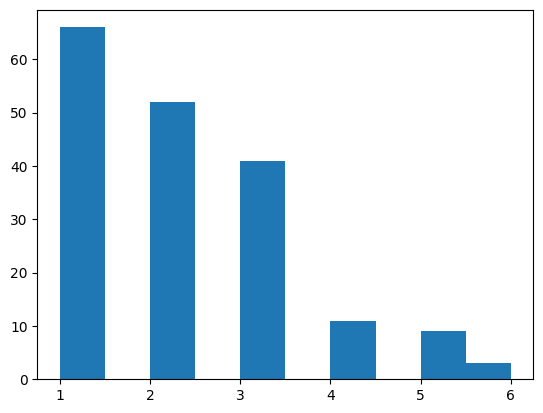

In [47]:
plt.hist(test_videos['sign'].value_counts());

### Convert videos to json

In [48]:
def process_video_sequential(video_path_df):
    # Initialize a list to store the results
    results = []

    # Create a progress bar
    progress_bar = tqdm(total=len(video_path_df), desc="Processing videos")

    # Iterate over the video paths
    for video_path in video_path_df:
        # Process the video and store the result
        process_video_to_landmarks_json(video_path, json_output=True, show_preview=False, save_annotated_video=False, frame_interval=1, rear_camera=True, skip_existing=True)

        # Update the progress bar
        progress_bar.update(1)


In [49]:
process_video_sequential(test_videos.video_path)

Processing videos:   7%|█████▌                                                                       | 29/400 [00:00<00:02, 144.78it/s]

Skipping video '39839' as landmarks file already exists.
Skipping video '63214' as landmarks file already exists.
Skipping video '62506' as landmarks file already exists.
Skipping video '65983' as landmarks file already exists.
Skipping video '66820' as landmarks file already exists.
Skipping video '69470' as landmarks file already exists.
Skipping video '46266' as landmarks file already exists.
Skipping video '22113' as landmarks file already exists.
Skipping video '03002' as landmarks file already exists.
Skipping video '27173' as landmarks file already exists.
Skipping video '34580' as landmarks file already exists.
Skipping video '08937' as landmarks file already exists.
Skipping video '17832' as landmarks file already exists.
Skipping video '25686' as landmarks file already exists.
Skipping video '17724' as landmarks file already exists.
Skipping video '39951' as landmarks file already exists.
Skipping video '05661' as landmarks file already exists.
Skipping video '26174' as landm

Processing videos:  11%|████████▍                                                                    | 44/400 [00:00<00:02, 132.06it/s]

Skipping video '03338' as landmarks file already exists.
Skipping video '69257' as landmarks file already exists.
Skipping video '10583' as landmarks file already exists.
Skipping video '59547' as landmarks file already exists.
Skipping video '06007' as landmarks file already exists.
Skipping video '11252' as landmarks file already exists.
Skipping video '48983' as landmarks file already exists.
Skipping video '06845' as landmarks file already exists.
Skipping video '54998' as landmarks file already exists.
Skipping video '03001' as landmarks file already exists.
Skipping video '04873' as landmarks file already exists.
Skipping video '07943' as landmarks file already exists.
Skipping video '34746' as landmarks file already exists.
Skipping video '17083' as landmarks file already exists.
Skipping video '60460' as landmarks file already exists.
Skipping video '14452' as landmarks file already exists.
Skipping video '62930' as landmarks file already exists.
Skipping video '26779' as landm

Processing videos:  18%|█████████████▍                                                               | 70/400 [00:00<00:03, 105.85it/s]

Skipping video '42231' as landmarks file already exists.
Skipping video '27153' as landmarks file already exists.
Skipping video '32326' as landmarks file already exists.
Skipping video '66561' as landmarks file already exists.
Skipping video '20636' as landmarks file already exists.
Skipping video '08514' as landmarks file already exists.
Skipping video '43220' as landmarks file already exists.
Skipping video '27406' as landmarks file already exists.
Skipping video '03342' as landmarks file already exists.
Skipping video '24614' as landmarks file already exists.
Skipping video '23628' as landmarks file already exists.
Skipping video '51504' as landmarks file already exists.
Skipping video '14177' as landmarks file already exists.
Skipping video '48043' as landmarks file already exists.
Skipping video '34584' as landmarks file already exists.
Skipping video '38525' as landmarks file already exists.
Skipping video '49182' as landmarks file already exists.
Skipping video '59555' as landm

Processing videos:  24%|██████████████████▊                                                          | 98/400 [00:00<00:02, 119.96it/s]

Skipping video '31750' as landmarks file already exists.
Skipping video '26003' as landmarks file already exists.
Skipping video '69305' as landmarks file already exists.
Skipping video '69343' as landmarks file already exists.
Skipping video '05634' as landmarks file already exists.
Skipping video '34824' as landmarks file already exists.
Skipping video '51340' as landmarks file already exists.
Skipping video '06794' as landmarks file already exists.
Skipping video '65125' as landmarks file already exists.
Skipping video '40465' as landmarks file already exists.
Skipping video '05654' as landmarks file already exists.
Skipping video '06789' as landmarks file already exists.
Skipping video '14174' as landmarks file already exists.
Skipping video '52354' as landmarks file already exists.
Skipping video '24581' as landmarks file already exists.
Skipping video '66774' as landmarks file already exists.
Skipping video '58807' as landmarks file already exists.
Skipping video '07068' as landm

Processing videos:  28%|█████████████████████▍                                                      | 113/400 [00:00<00:02, 128.25it/s]

Skipping video '69219' as landmarks file already exists.
Skipping video '21883' as landmarks file already exists.
Skipping video '38534' as landmarks file already exists.
Skipping video '52316' as landmarks file already exists.
Skipping video '22993' as landmarks file already exists.
Skipping video '66142' as landmarks file already exists.
Skipping video '24941' as landmarks file already exists.
Skipping video '26715' as landmarks file already exists.
Skipping video '04708' as landmarks file already exists.
Skipping video '25515' as landmarks file already exists.
Skipping video '60576' as landmarks file already exists.
Skipping video '26006' as landmarks file already exists.
Skipping video '26719' as landmarks file already exists.
Skipping video '56971' as landmarks file already exists.
Skipping video '57974' as landmarks file already exists.
Skipping video '58902' as landmarks file already exists.
Skipping video '25685' as landmarks file already exists.
Skipping video '21100' as landm

Processing videos:  36%|███████████████████████████▏                                                | 143/400 [00:01<00:02, 125.37it/s]

Skipping video '28737' as landmarks file already exists.
Skipping video '04169' as landmarks file already exists.
Skipping video '37043' as landmarks file already exists.
Skipping video '38532' as landmarks file already exists.
Skipping video '08114' as landmarks file already exists.
Skipping video '27408' as landmarks file already exists.
Skipping video '22085' as landmarks file already exists.
Skipping video '63201' as landmarks file already exists.
Skipping video '22746' as landmarks file already exists.
Skipping video '21874' as landmarks file already exists.
Skipping video '34091' as landmarks file already exists.
Skipping video '26009' as landmarks file already exists.
Skipping video '36858' as landmarks file already exists.
Skipping video '48510' as landmarks file already exists.
Skipping video '33465' as landmarks file already exists.
Skipping video '21870' as landmarks file already exists.
Skipping video '34830' as landmarks file already exists.
Skipping video '69536' as landm

Processing videos:  43%|████████████████████████████████▍                                           | 171/400 [00:01<00:01, 121.95it/s]

Skipping video '21175' as landmarks file already exists.
Skipping video '54762' as landmarks file already exists.
Skipping video '63283' as landmarks file already exists.
Skipping video '24582' as landmarks file already exists.
Skipping video '40129' as landmarks file already exists.
Skipping video '27999' as landmarks file already exists.
Skipping video '20700' as landmarks file already exists.
Skipping video '09307' as landmarks file already exists.
Skipping video '32320' as landmarks file already exists.
Skipping video '14572' as landmarks file already exists.
Skipping video '54557' as landmarks file already exists.
Skipping video '48973' as landmarks file already exists.
Skipping video '17823' as landmarks file already exists.
Skipping video '69211' as landmarks file already exists.
Skipping video '23630' as landmarks file already exists.
Skipping video '50122' as landmarks file already exists.
Skipping video '62510' as landmarks file already exists.
Skipping video '54955' as landm

Processing videos:  50%|██████████████████████████████████████                                      | 200/400 [00:01<00:01, 124.95it/s]

Skipping video '24584' as landmarks file already exists.
Skipping video '05644' as landmarks file already exists.
Skipping video '09528' as landmarks file already exists.
Skipping video '69395' as landmarks file already exists.
Skipping video '17428' as landmarks file already exists.
Skipping video '46733' as landmarks file already exists.
Skipping video '54764' as landmarks file already exists.
Skipping video '58031' as landmarks file already exists.
Skipping video '09305' as landmarks file already exists.
Skipping video '40130' as landmarks file already exists.
Skipping video '27417' as landmarks file already exists.
Skipping video '02003' as landmarks file already exists.
Skipping video '66766' as landmarks file already exists.
Skipping video '65427' as landmarks file already exists.
Skipping video '43528' as landmarks file already exists.
Skipping video '24955' as landmarks file already exists.
Skipping video '49181' as landmarks file already exists.
Skipping video '04361' as landm

Processing videos:  57%|███████████████████████████████████████████▌                                | 229/400 [00:01<00:01, 131.41it/s]

Skipping video '06075' as landmarks file already exists.
Skipping video '27375' as landmarks file already exists.
Skipping video '66705' as landmarks file already exists.
Skipping video '06832' as landmarks file already exists.
Skipping video '65167' as landmarks file already exists.
Skipping video '52348' as landmarks file already exists.
Skipping video '60459' as landmarks file already exists.
Skipping video '07963' as landmarks file already exists.
Skipping video '66328' as landmarks file already exists.
Skipping video '21891' as landmarks file already exists.
Skipping video '32094' as landmarks file already exists.
Skipping video '08510' as landmarks file already exists.
Skipping video '51058' as landmarks file already exists.
Skipping video '28003' as landmarks file already exists.
Skipping video '36780' as landmarks file already exists.
Skipping video '37040' as landmarks file already exists.
Skipping video '04870' as landmarks file already exists.
Skipping video '09533' as landm

Processing videos:  65%|█████████████████████████████████████████████████▍                          | 260/400 [00:02<00:01, 136.95it/s]

Skipping video '49188' as landmarks file already exists.
Skipping video '56563' as landmarks file already exists.
Skipping video '69429' as landmarks file already exists.
Skipping video '07070' as landmarks file already exists.
Skipping video '66643' as landmarks file already exists.
Skipping video '05728' as landmarks file already exists.
Skipping video '69317' as landmarks file already exists.
Skipping video '64281' as landmarks file already exists.
Skipping video '51503' as landmarks file already exists.
Skipping video '06002' as landmarks file already exists.
Skipping video '06334' as landmarks file already exists.
Skipping video '01724' as landmarks file already exists.
Skipping video '60574' as landmarks file already exists.
Skipping video '56978' as landmarks file already exists.
Skipping video '52867' as landmarks file already exists.
Skipping video '20634' as landmarks file already exists.
Skipping video '66740' as landmarks file already exists.
Skipping video '65668' as landm

Processing videos:  68%|████████████████████████████████████████████████████                        | 274/400 [00:02<00:00, 137.34it/s]

Skipping video '03003' as landmarks file already exists.
Skipping video '32337' as landmarks file already exists.
Skipping video '49432' as landmarks file already exists.
Skipping video '69239' as landmarks file already exists.
Skipping video '06477' as landmarks file already exists.
Skipping video '48050' as landmarks file already exists.
Skipping video '39635' as landmarks file already exists.
Skipping video '65540' as landmarks file already exists.
Skipping video '24583' as landmarks file already exists.
Skipping video '66709' as landmarks file already exists.
Skipping video '64305' as landmarks file already exists.
Skipping video '05629' as landmarks file already exists.
Skipping video '05742' as landmarks file already exists.
Skipping video '17582' as landmarks file already exists.
Skipping video '33286' as landmarks file already exists.
Skipping video '45759' as landmarks file already exists.
Skipping video '14566' as landmarks file already exists.
Skipping video '10587' as landm

Processing videos:  76%|█████████████████████████████████████████████████████████▍                  | 302/400 [00:02<00:00, 129.11it/s]

Skipping video '11035' as landmarks file already exists.
Skipping video '41902' as landmarks file already exists.
Skipping video '25508' as landmarks file already exists.
Skipping video '69366' as landmarks file already exists.
Skipping video '40659' as landmarks file already exists.
Skipping video '59548' as landmarks file already exists.
Skipping video '66552' as landmarks file already exists.
Skipping video '26942' as landmarks file already exists.
Skipping video '69510' as landmarks file already exists.
Skipping video '08107' as landmarks file already exists.
Skipping video '33454' as landmarks file already exists.
Skipping video '37612' as landmarks file already exists.
Skipping video '28379' as landmarks file already exists.
Skipping video '40121' as landmarks file already exists.
Skipping video '02826' as landmarks file already exists.
Skipping video '02999' as landmarks file already exists.
Skipping video '24589' as landmarks file already exists.
Skipping video '34839' as landm

Processing videos:  83%|███████████████████████████████████████████████████████████████             | 332/400 [00:02<00:00, 135.39it/s]

Skipping video '69283' as landmarks file already exists.
Skipping video '43522' as landmarks file already exists.
Skipping video '33456' as landmarks file already exists.
Skipping video '17721' as landmarks file already exists.
Skipping video '17722' as landmarks file already exists.
Skipping video '22994' as landmarks file already exists.
Skipping video '24548' as landmarks file already exists.
Skipping video '14481' as landmarks file already exists.
Skipping video '66405' as landmarks file already exists.
Skipping video '34827' as landmarks file already exists.
Skipping video '10453' as landmarks file already exists.
Skipping video '64306' as landmarks file already exists.
Skipping video '52617' as landmarks file already exists.
Skipping video '08942' as landmarks file already exists.
Skipping video '63287' as landmarks file already exists.
Skipping video '17091' as landmarks file already exists.
Skipping video '28377' as landmarks file already exists.
Skipping video '52623' as landm

Processing videos:  90%|████████████████████████████████████████████████████████████████████▊       | 362/400 [00:02<00:00, 137.22it/s]

Skipping video '17935' as landmarks file already exists.
Skipping video '60571' as landmarks file already exists.
Skipping video '28381' as landmarks file already exists.
Skipping video '21101' as landmarks file already exists.
Skipping video '25423' as landmarks file already exists.
Skipping video '34832' as landmarks file already exists.
Skipping video '24641' as landmarks file already exists.
Skipping video '34375' as landmarks file already exists.
Skipping video '27412' as landmarks file already exists.
Skipping video '14188' as landmarks file already exists.
Skipping video '33274' as landmarks file already exists.
Skipping video '21858' as landmarks file already exists.
Skipping video '65372' as landmarks file already exists.
Skipping video '57973' as landmarks file already exists.
Skipping video '19843' as landmarks file already exists.
Skipping video '17720' as landmarks file already exists.
Skipping video '55804' as landmarks file already exists.
Skipping video '06933' as landm

Processing videos:  98%|██████████████████████████████████████████████████████████████████████████  | 390/400 [00:03<00:00, 128.54it/s]

Skipping video '06839' as landmarks file already exists.
Skipping video '22558' as landmarks file already exists.
Skipping video '66415' as landmarks file already exists.
Skipping video '33269' as landmarks file already exists.
Skipping video '22996' as landmarks file already exists.
Skipping video '10447' as landmarks file already exists.
Skipping video '17589' as landmarks file already exists.
Skipping video '59058' as landmarks file already exists.
Skipping video '69236' as landmarks file already exists.
Skipping video '56557' as landmarks file already exists.
Skipping video '26717' as landmarks file already exists.
Skipping video '21853' as landmarks file already exists.
Skipping video '34734' as landmarks file already exists.
Skipping video '26710' as landmarks file already exists.
Skipping video '24606' as landmarks file already exists.
Skipping video '22120' as landmarks file already exists.
Skipping video '08938' as landmarks file already exists.
Skipping video '31749' as landm

Processing videos: 100%|████████████████████████████████████████████████████████████████████████████| 400/400 [00:03<00:00, 126.47it/s]

Skipping video '69206' as landmarks file already exists.
Skipping video '21863' as landmarks file already exists.
Skipping video '65354' as landmarks file already exists.
Skipping video '11034' as landmarks file already exists.
Skipping video '60907' as landmarks file already exists.


In [50]:
# create json_path column
test_videos['json_path'] = test_videos['video_path'].apply(lambda x: os.path.join(LANDMARKS_VIDEO_DIR, f'{os.path.splitext(os.path.basename(x))[0]}_landmarks.json'))
test_videos.head()

,sign,bbox,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,video_path,json_path
1125,on,"[29, 0, 267, 240]",25,-1,1,3,37,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/4...,0,39839,/home/bfrisque/code/benoitfrisque/signlens/raw...,/home/bfrisque/code/benoitfrisque/signlens/pro...
184,white,"[183, 52, 544, 400]",25,-1,1,16,12,aslsearch,train,http://www.aslsearch.com/signs/videos/white.mp4,0,63214,/home/bfrisque/code/benoitfrisque/signlens/raw...,/home/bfrisque/code/benoitfrisque/signlens/pro...
1226,water,"[89, 22, 204, 192]",25,-1,1,6,10,signingsavvy,train,https://www.signingsavvy.com/signs/mp4/22/2297...,0,62506,/home/bfrisque/code/benoitfrisque/signlens/raw...,/home/bfrisque/code/benoitfrisque/signlens/pro...
67,jump,"[167, 16, 480, 370]",25,-1,1,1,90,aslsignbank,train,https://aslsignbank.haskins.yale.edu/dictionar...,0,65983,/home/bfrisque/code/benoitfrisque/signlens/raw...,/home/bfrisque/code/benoitfrisque/signlens/pro...
220,yes,"[168, 14, 461, 370]",25,-1,1,13,88,aslsignbank,train,https://aslsignbank.haskins.yale.edu/dictionar...,0,66820,/home/bfrisque/code/benoitfrisque/signlens/raw...,/home/bfrisque/code/benoitfrisque/signlens/pro...


### Preprocess json

In [51]:
json_path = test_videos.json_path.iloc[0]

with open(json_path) as f:
    json_data = json.load(f)

data_processed_tf = preprocess_data_from_json_data(json_data)

In [52]:
# Initialize an empty list to store processed data
processed_data_list = []

# Assuming test_videos is a DataFrame with column json_path
for json_path in tqdm(test_videos['json_path']):
    with open(json_path) as f:
        json_data = json.load(f)

    data_processed_tf = preprocess_data_from_json_data(json_data)
    processed_data_list.append(data_processed_tf)

X_test_videos = tf.concat(processed_data_list, axis=0)


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:09<00:00, 44.36it/s]


In [53]:
noface=True
n_coordinates = 2
n_frames = 100


# Initialize an empty list to store processed data
processed_data_list = []

# Assuming test_videos is a DataFrame with column json_path
for json_path in tqdm(test_videos['json_path']):
    with open(json_path) as f:
        json_data = json.load(f)
    
    landmarks_df = convert_landmarks_json_data_to_df(json_data)
    filtered_landmarks_array = filter_relevant_landmarks_and_coordinates(landmarks_df, noface=noface, n_coordinates=n_coordinates)
    data_processed = pad_and_preprocess_landmarks_array(filtered_landmarks_array, n_frames=n_frames)
    processed_data_list.append(data_processed)

processs_data_np = np.array(processed_data_list)
X_test_videos2 = reshape_processed_data_to_tf(processs_data_np, noface=noface, n_frames=n_frames, n_coordinates=n_coordinates)


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:08<00:00, 46.03it/s]


In [54]:
X_test_videos2.shape

TensorShape([400, 100, 134])

### Model prediction

In [55]:
y_test_videos = encode_labels(test_videos.sign)

In [56]:
test_videos.sign

1125           on
184         white
1226        water
67           jump
220           yes
          ...    
704           all
126          find
660     chocolate
292         clean
982            up
Name: sign, Length: 400, dtype: object

In [57]:
y_test_videos.shape

(400, 250)

In [58]:
evaluate_model(model, X_test_videos, y_test_videos)


Evaluating model on 400 rows...
✅ Model evaluated, accuracy: 11.2%


{'accuracy': 0.11249999701976776, 'loss': 5.712578773498535}

In [59]:
evaluate_model(model, X_test_videos2, y_test_videos)


Evaluating model on 400 rows...
✅ Model evaluated, accuracy: 11.2%


{'accuracy': 0.11249999701976776, 'loss': 5.712578773498535}

### Second trial of preprocessing


#### From parquet

In [28]:
X_test_files.loc[0]

'/home/bfrisque/code/benoitfrisque/signlens/raw_data/asl-signs/train_landmark_files_noface/55372/964553686.parquet'

In [29]:
pq_df = pd.read_parquet(X_test_files.loc[0])
pq_df

,frame,row_id,type,landmark_index,x,y,z
468,97,97-left_hand-0,left_hand,0,0.753712,0.440771,-3.072535e-07
469,97,97-left_hand-1,left_hand,1,0.710808,0.387376,1.541814e-02
470,97,97-left_hand-2,left_hand,2,0.684510,0.326742,5.668570e-03
471,97,97-left_hand-3,left_hand,3,0.661984,0.284918,-9.025068e-03
472,97,97-left_hand-4,left_hand,4,0.633150,0.261813,-2.736259e-02
...,...,...,...,...,...,...,...
15199,124,124-right_hand-16,right_hand,16,NaN,NaN,NaN
15200,124,124-right_hand-17,right_hand,17,NaN,NaN,NaN
15201,124,124-right_hand-18,right_hand,18,NaN,NaN,NaN
15202,124,124-right_hand-19,right_hand,19,NaN,NaN,NaN


In [30]:
pq_df[pq_df.type=='pose']

,frame,row_id,type,landmark_index,x,y,z
489,97,97-pose-0,pose,0,0.486289,0.378977,-1.222383
490,97,97-pose-1,pose,1,0.515095,0.311778,-1.133345
491,97,97-pose-2,pose,2,0.539201,0.312966,-1.132728
492,97,97-pose-3,pose,3,0.562195,0.314196,-1.132530
493,97,97-pose-4,pose,4,0.438257,0.307604,-1.181726
...,...,...,...,...,...,...,...
15178,124,124-pose-28,pose,28,0.274367,2.496219,1.476208
15179,124,124-pose-29,pose,29,0.690214,2.568291,1.342841
15180,124,124-pose-30,pose,30,0.257715,2.570974,1.555213
15181,124,124-pose-31,pose,31,0.662896,2.661493,0.384620


In [31]:
pq_df.describe()

,frame,landmark_index,x,y,z
count,2100.000000,2100.000000,1449.000000,1449.000000,1449.000000
mean,110.500000,12.640000,0.520995,0.810090,-0.323313
std,8.079671,8.326469,0.242960,0.778027,0.668098
min,97.000000,0.000000,-0.125702,0.097004,-1.879110
25%,103.750000,6.000000,0.406232,0.306133,-0.963419
50%,110.500000,12.000000,0.615779,0.369245,-0.089416
75%,117.250000,18.000000,0.685205,1.357148,-0.003270
max,124.000000,32.000000,0.980260,2.663223,1.594750


In [32]:
landmarks_df = pq_df

noface = True
n_coordinates = 2

# Keep only the defined columns
landmarks_df = landmarks_df[['frame', 'type','landmark_index', 'x', 'y', 'z']]

# Define the order of the 'type' column
type_order = ['face', 'pose', 'left_hand', 'right_hand']

# Convert the 'type' column to a categorical type with the specified order
landmarks_df['type'] = pd.Categorical(landmarks_df['type'], categories=type_order, ordered=True)

# Sort the DataFrame by 'frame', 'type' and 'landmark_index', to ensure the correct order of landmarks
landmarks_df.sort_values(by=['frame', 'type', 'landmark_index'], inplace=True)

n_landmarks_per_frame = N_LANDMARKS_ALL

landmark_types_to_remove = []

if noface:
    # Exclude rows where 'type' is 'face' and some portion of 'pose'
    landmark_types_to_remove.append('face')

    # Calculate the number of rows per frame after removing 'face' landmarks
    n_landmarks_per_frame -= N_LANDMARKS_FACE

if N_LANDMARKS_POSE_TO_TAKE_OFF > 0:
    landmark_types_to_remove.append('pose')

    # Calculate the number of rows per frame after removing 'pose' landmarks
    n_landmarks_per_frame -= N_LANDMARKS_POSE_TO_TAKE_OFF

for landmark_type in landmark_types_to_remove:
    if landmark_type == 'pose' and N_LANDMARKS_POSE_TO_TAKE_OFF > 0:
        landmarks_df = landmarks_df[~((landmarks_df['type'] == 'pose') &
                                      (landmarks_df['landmark_index'].\
                                          between(N_LANDMARKS_MIN_POSE_TO_TAKE_OFF, N_LANDMARKS_MAX_POSE_TO_TAKE_OFF)))
                                    ]
    else:
        landmarks_df = landmarks_df[landmarks_df['type'] != landmark_type]

# If the model uses 2D data, drop the 'z' dimension
if n_coordinates == 2:
    data_columns = ['x', 'y']
else:
    # If the model uses 3D data, keep the 'z' dimension
    data_columns = ['x', 'y', 'z']

pq_df_filtered = landmarks_df
pq_df_filtered

/tmp/ipykernel_32672/1063850012.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  landmarks_df['type'] = pd.Categorical(landmarks_df['type'], categories=type_order, ordered=True)
/tmp/ipykernel_32672/1063850012.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  landmarks_df.sort_values(by=['frame', 'type', 'landmark_index'], inplace=True)


,frame,type,landmark_index,x,y,z
489,97,pose,0,0.486289,0.378977,-1.222383
490,97,pose,1,0.515095,0.311778,-1.133345
491,97,pose,2,0.539201,0.312966,-1.132728
492,97,pose,3,0.562195,0.314196,-1.132530
493,97,pose,4,0.438257,0.307604,-1.181726
...,...,...,...,...,...,...
15199,124,right_hand,16,NaN,NaN,NaN
15200,124,right_hand,17,NaN,NaN,NaN
15201,124,right_hand,18,NaN,NaN,NaN
15202,124,right_hand,19,NaN,NaN,NaN


In [33]:
landmarks_array = filter_relevant_landmarks_and_coordinates(pq_df)
landmarks_array.shape

/home/bfrisque/code/benoitfrisque/signlens/signlens/preprocessing/preprocess.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  landmarks_df['type'] = pd.Categorical(landmarks_df['type'], categories=type_order, ordered=True)
/home/bfrisque/code/benoitfrisque/signlens/signlens/preprocessing/preprocess.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  landmarks_df.sort_values(by=['frame', 'type', 'landmark_index'], inplace=True)


(28, 67, 2)

### From json

In [34]:
from signlens.preprocessing.preprocess import convert_landmarks_json_data_to_df

In [35]:
json_df = convert_landmarks_json_data_to_df(json_data)
json_df

,frame,type,landmark_index,x,y,z
0,0,pose,0,0.500277,0.241630,-0.819381
1,0,pose,1,0.523893,0.202014,-0.776747
2,0,pose,2,0.536773,0.200921,-0.776917
3,0,pose,3,0.550744,0.200229,-0.776974
4,0,pose,4,0.477402,0.203587,-0.779479
...,...,...,...,...,...,...
6587,87,right_hand,16,NaN,NaN,NaN
6588,87,right_hand,17,NaN,NaN,NaN
6589,87,right_hand,18,NaN,NaN,NaN
6590,87,right_hand,19,NaN,NaN,NaN


In [36]:
json_df.describe()

,frame,landmark_index,x,y,z
count,6592.000000,6592.000000,4257.000000,4257.000000,4257.000000
mean,43.447209,12.620752,0.496357,0.754882,-0.313627
std,25.373836,8.311416,0.095192,0.633905,0.551877
min,0.000000,0.000000,0.277233,0.073954,-1.978260
25%,21.000000,6.000000,0.427348,0.258638,-0.637832
50%,43.000000,12.000000,0.473865,0.456491,-0.062060
75%,65.000000,18.000000,0.554626,1.199271,-0.006266
max,87.000000,32.000000,0.720620,2.234679,0.978589


In [37]:
landmarks_df = json_df

noface = True
n_coordinates = 2

# Keep only the defined columns
landmarks_df = landmarks_df[['frame', 'type','landmark_index', 'x', 'y', 'z']]

# Define the order of the 'type' column
type_order = ['face', 'pose', 'left_hand', 'right_hand']

# Convert the 'type' column to a categorical type with the specified order
landmarks_df['type'] = pd.Categorical(landmarks_df['type'], categories=type_order, ordered=True)

# Sort the DataFrame by 'frame', 'type' and 'landmark_index', to ensure the correct order of landmarks
landmarks_df.sort_values(by=['frame', 'type', 'landmark_index'], inplace=True)

n_landmarks_per_frame = N_LANDMARKS_ALL

landmark_types_to_remove = []

if noface:
    # Exclude rows where 'type' is 'face' and some portion of 'pose'
    landmark_types_to_remove.append('face')

    # Calculate the number of rows per frame after removing 'face' landmarks
    n_landmarks_per_frame -= N_LANDMARKS_FACE

if N_LANDMARKS_POSE_TO_TAKE_OFF > 0:
    landmark_types_to_remove.append('pose')

    # Calculate the number of rows per frame after removing 'pose' landmarks
    n_landmarks_per_frame -= N_LANDMARKS_POSE_TO_TAKE_OFF

for landmark_type in landmark_types_to_remove:
    if landmark_type == 'pose' and N_LANDMARKS_POSE_TO_TAKE_OFF > 0:
        landmarks_df = landmarks_df[~((landmarks_df['type'] == 'pose') &
                                      (landmarks_df['landmark_index'].\
                                          between(N_LANDMARKS_MIN_POSE_TO_TAKE_OFF, N_LANDMARKS_MAX_POSE_TO_TAKE_OFF)))
                                    ]
    else:
        landmarks_df = landmarks_df[landmarks_df['type'] != landmark_type]

# If the model uses 2D data, drop the 'z' dimension
if n_coordinates == 2:
    data_columns = ['x', 'y']
else:
    # If the model uses 3D data, keep the 'z' dimension
    data_columns = ['x', 'y', 'z']

json_df_filtered = landmarks_df
json_df_filtered

,frame,type,landmark_index,x,y,z
0,0,pose,0,0.500277,0.241630,-0.819381
1,0,pose,1,0.523893,0.202014,-0.776747
2,0,pose,2,0.536773,0.200921,-0.776917
3,0,pose,3,0.550744,0.200229,-0.776974
4,0,pose,4,0.477402,0.203587,-0.779479
...,...,...,...,...,...,...
6587,87,right_hand,16,NaN,NaN,NaN
6588,87,right_hand,17,NaN,NaN,NaN
6589,87,right_hand,18,NaN,NaN,NaN
6590,87,right_hand,19,NaN,NaN,NaN


In [38]:
filtered_json_landmarks = filter_relevant_landmarks_and_coordinates(json_df)
filtered_json_landmarks

array([[[0.5002772 , 0.24163002],
        [0.52389276, 0.20201373],
        [0.5367728 , 0.20092052],
        ...,
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan]],

       [[0.5002266 , 0.24465053],
        [0.52411956, 0.20562889],
        [0.53825974, 0.20565483],
        ...,
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan]],

       [[0.49976858, 0.24701318],
        [0.5241101 , 0.20794415],
        [0.53887725, 0.2082071 ],
        ...,
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan]],

       ...,

       [[0.51805407, 0.24005097],
        [0.54111457, 0.20181601],
        [0.5575814 , 0.20250034],
        ...,
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan]],

       [[0.5178125 , 0.24015513],
        [0.54079664, 0.20201138],
        [0.55711925, 0.2028787 ],
        .

### Compare filtering and sorting

In [39]:
order_pq = pq_df_filtered[pq_df_filtered.frame==97][['type', 'landmark_index']].reset_index(drop=True)
order_pq

,type,landmark_index
0,pose,0
1,pose,1
2,pose,2
3,pose,3
4,pose,4
...,...,...
62,right_hand,16
63,right_hand,17
64,right_hand,18
65,right_hand,19


In [40]:
order_json = json_df_filtered[json_df_filtered.frame==0][['type', 'landmark_index']].reset_index(drop=True)
order_json 

,type,landmark_index
0,pose,0
1,pose,1
2,pose,2
3,pose,3
4,pose,4
...,...,...
62,right_hand,16
63,right_hand,17
64,right_hand,18
65,right_hand,19


In [41]:
(order_pq == order_json).sum()

type              67
landmark_index    67
dtype: int64